# Practical 2: Supervised Image Classification for Glaciers

Content prepared by Swun Wunna Htet

___

From this practical notebook, you will learn:

1. How to prepare image for classification
2. Random Forest Classification
3. Accuracy Assessment

## 1: install GEE python API in the colab environment

In [ ]:
! pip install geemap

! pip install pycrs
! pip install geetools

## 2: import python libraries to utilize

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd

import ee
import geemap

## 3: Authenticate and initialize earthe engine. If you have a specific GEE projects specify that project

In [2]:
ee.Authenticate()
ee.Initialize(project = 'ee-swunait')

Connecting with your google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 4: Import AOI shapefile into GEE asset.

First we will upload our area of interest into GEE asset. In case you have error message _No Module named pycrs_, run this code in a new cell `py install pycrs`.

In [4]:
aoi = geemap.shp_to_ee(r'/content/drive/MyDrive/Bhutan_2nd_training/AOI/aoi.shp')

In [5]:
# Let's see our metadata of aoi. AOI is now termed as Feature Collection.
display(aoi)

## 5: we're going to use two Landsat image collection representing 2020 and 2021

In [6]:
start = ee.Date('2020-01-01') # first image of the accumulation year
end = ee.Date('2020-12-31') # the last image of the ablation year
col = ee.ImageCollection("NASA/HLS/HLSL30/v002").filterBounds(aoi).filterDate(start, end) # Harmonized Landsat Image

In [7]:
display(col)

The band list of the selected image collection are as follows. Note that the band names for image collections will have different names. So, make sure you change your band names according to the band description.

|Band Name|Description|
|---|---|
|B1|Coastal Aerosol|
|B2|Blue|
|B3|Green|
|B4|Red|
|B5|NIR|
|B6|SWIR1|
|B7|SWIR2|
|B9|Cirrus|
|B10|TIRS1 (Thermal Infrared)|
|B11|TIRS2 (Thermal Infrared)|

## 6: We're preprocessing all the images in the image collection by quality masking.

In [8]:
# function to calculate NDSI
def QAmask(img):
  # clipping into area of interest
  image = img.clip(aoi)

  # Apply quality mask using 'Fmask' band
  fmask = image.select('Fmask')

  # Mask out cloud and shadow pixels
  not_cloud = fmask.bitwiseAnd(1 << 1).eq(0)     # bit 1 = cloud
  not_shadow = fmask.bitwiseAnd(1 << 3).eq(0)    # bit 3 = shadow

  # Keep pixels that are neither cloud nor shadow
  clear_mask = not_cloud.And(not_shadow)

  # Apply the mask to the image
  image2 = image.updateMask(clear_mask)

  return ee.Image(image2.copyProperties(img, ['system:time_start']))

In [9]:
# Applying QA masking to imagecollection
colQA = col.map(QAmask)

In [10]:
display(colQA)

Now, we'll create a single representative map of 2020.

In [12]:
# Remove the QA bands
bands = [f'B{i}' for i in range(1,12)]
del(bands[7])
print(bands)

# Creating a median map of the area
img2020 = colQA.median().select(bands)

display(img2020)

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'B10', 'B11']


## 7: Next, we're sampling ground truths to feed into ML algorithm.

In [13]:
Map = geemap.Map(center = [28.197, 90.25], zoom = 10.5)

# visualization settings in map
params = {'bands': ['B7', 'B5', 'B3'], 'gamma': 1.0, 'min': 0.12, 'max': 1.0}

# adding area of interest and the two selected images
Map.addLayer(aoi, {'color': 'blue', 'opacity': 0.5}, 'Area of Interest')
Map.addLayer(img2020, params,'2020')

In [14]:
Map

Map(center=[28.197, 90.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

Note that you have to go one land cover type of each sample and save as Feature Collection. Later, all different land covers will be merged together.

In [15]:
land = Map.user_rois

In [17]:
snow = Map.user_rois

In [19]:
water= Map.user_rois

In [20]:
display(water)

In [21]:
ice = Map.user_rois

In [45]:
training = ee.FeatureCollection([land, snow, water, ice]).flatten()

display(training)

Once the samples are collected, we will split the sample portions randomly (70% for training and 30% for accuracy assessment).

In [46]:
# 1. Add a random number column
samplesWithRandom = training.randomColumn('random');

#  2. Split 70% for training (random < 0.7)
training = samplesWithRandom.filter(ee.Filter.lt('random', 0.7));

# 3. Split 30% for validation (random >= 0.7)
validation = samplesWithRandom.filter(ee.Filter.gte('random', 0.7));

In [47]:
display(training)

We have collected all the training points from the map. Now, we're extracting the values from image to classify. Note that our image has quality bands which needs to be removed.


In [48]:
img2020 = img2020.select(bands)
display(img2020)

# sample the SR from the image
training = img2020.sampleRegions(
    collection = training,
    properties = ['LC'],
    scale = 30
)

display(training)

In [50]:
# Run the classifier
RFclassifier = ee.Classifier.smileRandomForest(50).train(
    features = training,
    classProperty = 'LC',
    inputProperties = bands
)

LC2020 = img2020.classify(RFclassifier)
display(LC2020)

## 8: Now, let's conduct accuracy assessment starting from confusion matrix

The following investigation is to check whether the classifier has some confusion in classification or not.

In [52]:
test_CFM = RFclassifier.confusionMatrix()
display('Validation error matrix:', test_CFM.getInfo())
display('Validation overall accuracy:', test_CFM.accuracy().getInfo())

'Validation error matrix:'

[[0, 0, 0, 0, 0],
 [0, 46, 0, 0, 0],
 [0, 0, 30, 0, 0],
 [0, 0, 0, 33, 0],
 [0, 0, 0, 0, 11]]

'Validation overall accuracy:'

1

Now, we will use the 30% portion to test the accuracy with the original Landsat 8 SR bands.

In [58]:
validated = img2020.sampleRegions(
    collection = validation,
    properties = ['LC'],
    scale = 30
)

In [59]:
display(validated)

Classify the input imagery and Validate

In [60]:
validated2 = validated.classify(RFclassifier)

conf_matrix = validated2.errorMatrix('LC', 'classification')
print('Confusion Matrix', conf_matrix.getInfo())
print('Overall Accuracy', conf_matrix.accuracy().getInfo())
print('Kappa Coefficient', conf_matrix.kappa().getInfo())

Confusion Matrix [[0, 0, 0, 0, 0], [0, 13, 0, 0, 1], [0, 0, 17, 0, 0], [0, 0, 0, 11, 0], [0, 0, 0, 0, 5]]
Overall Accuracy 0.9787234042553191
Kappa Coefficient 0.9703843730308759


Generally, over 80% accuracy is a consistent model output.

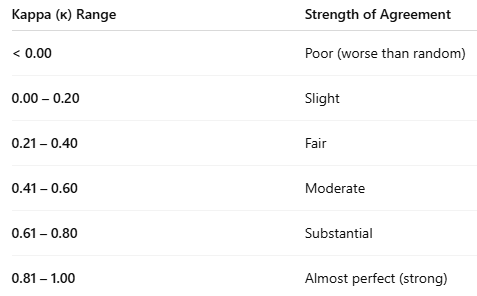

Upload the Land cover in Map

In [61]:
# Adding the LC layer to the Map
lcparams = {'min':1, 'max':4, 'palette':['#0000FF','#808080','#A0522D','#00FF00']}
Map.addLayer(LC2020, lcparams, 'LC2020')

Let's test the classifier of Random Forest to another image.

## 9: Now, that we have the land cover map, the accuracy assessment is required the conduct for data quality consistency.



In [ ]:
task = ee.batch.Export.image.toDrive(
    image= LC2020,
    description='LC2020',
    folder='Day6_Practical',
    region= aoi.geometry(),
    scale=30,
    crs='EPSG:32646'
)
task.start()

__

END of Practical 1
___
